# Integration of CITE-seq and scRNA-seq data with totalVI

Here we demonstrate how to integrate CITE-seq and scRNA-seq datasets with totalVI. The same principles here can be used to integrate CITE-seq datasets with different sets of measured proteins.

If running in Colab, navigate to Runtime -> Change runtime type and ensure you're using a Python 3 runtime with GPU hardware accelerator installation in Colab can take several minutes.



[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/yoseflab/scvi/blob/stable/docs/tutorials/cite_scrna_integration_w_totalVI.ipynb)

In [0]:
import sys
IN_COLAB = "google.colab" in sys.modules

if IN_COLAB:
    !pip install --quiet git+https://github.com/yoseflab/scvi@total_updates#egg=scvi[notebooks]

In [2]:
import scvi
print(scvi.__version__)

0.6.4


## Imports and data loading

In [3]:
import scanpy as sc
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import anndata
import os
import seaborn as sns
from plotnine import *

from scvi.dataset import AnnDatasetFromAnnData, CellMeasurement, GeneExpressionDataset
from scvi.models import TOTALVI
from scvi.inference import TotalPosterior, TotalTrainer
from scvi import set_seed


if IN_COLAB:
    %matplotlib inline

# Sets the random seed for torch and numpy
set_seed(0)

sc.set_figure_params(figsize=(4, 4))

/usr/local/lib/python3.6/dist-packages/anndata/_core/anndata.py:21: FutureWarning: pandas.core.index is deprecated and will be removed in a future version.  The public classes are available in the top-level namespace.
  from pandas.core.index import RangeIndex
/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Here we focus on two CITE-seq datasets of peripheral blood mononuclear cells from 10x Genomics and used in the totalVI manuscript. We have already filtered these datasets for doublets and low-quality cells and genes.

The quality of totalVI's protein imputation is somewhat reliant on how well the datasets mix in the latent space. In other words, it's assumed here the datasets largely share the same cell subpopulations.

Now we load the anndata objects. To load CITE-seq data into the anndata format, we refer to the scanpy API. Each of these downloaded objects has the protein expression (cells by proteins) in `adata.obsm["protein_expression"]` and the corresponding names for each of the columns in `adata.uns["protein_names"]`. Some manipulation will be required to get the adata into this form.

In the base totalVI tutorial, we showed how to download and load these datasets from the scVI API. Here we demonstrate how to use the scanpy API and then load a local AnnData object into totalVI. This could be useful if you'd like to use Scanpy for preprocessing.

In [4]:
pbmc_10k_adata = sc.read("pbmc_10k_protein_v3.h5ad", backup_url="https://github.com/YosefLab/scVI-data/raw/master/pbmc_10k_protein_v3.h5ad")
pbmc_5k_adata = sc.read("pbmc_5k_protein_v3.h5ad", backup_url="https://github.com/YosefLab/scVI-data/raw/master/pbmc_5k_protein_v3.h5ad")

For example, 
```python
import scanpy as sc
adata = sc.read_10x_mtx(save_path_10x, gex_only=False)
adata.obsm["protein_expression"] = adata[
    :, adata.var["feature_types"] == "Antibody Capture"
].X.A
adata.uns["protein_names"] = np.array(
    adata.var_names[adata.var["feature_types"] == "Antibody Capture"]
)
adata = adata[
    :, adata.var["feature_types"] != "Antibody Capture"
].copy()
adata.X = adata.X.A
adata.var_names_make_unique()
```
In this example we chose to make the counts dense (the `.A` code), this will be hardware specific. In general, totalVI will be faster if everything is loaded as dense, because each minibatch of data loaded to the model is made dense anyway.

Now we load the local AnnData objects into totalVI.

In [5]:
dataset_10k = AnnDatasetFromAnnData(pbmc_10k_adata, cell_measurements_col_mappings={"protein_expression":"protein_names"})
dataset_5k = AnnDatasetFromAnnData(pbmc_5k_adata, cell_measurements_col_mappings={"protein_expression":"protein_names"})

[2020-04-28 00:27:58,032] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-28 00:27:58,033] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-28 00:28:01,651] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-28 00:28:01,789] INFO - scvi.dataset.dataset | Downsampled from 6855 to 6855 cells
[2020-04-28 00:28:01,939] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-28 00:28:01,940] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-28 00:28:03,929] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-28 00:28:04,009] INFO - scvi.dataset.dataset | Downsampled from 3994 to 3994 cells


Notice that the 5k dataset has more proteins than the 10k dataset

In [6]:
print(dataset_10k.protein_names.shape)
print(dataset_5k.protein_names.shape)

(14,)
(29,)


The following code will combine the two datasets, including intersecting genes and proteins. We also select highly variable genes (HVG), which by default uses a modified Seurat v3 procedure, which also merges HVGs from the different batches.

In [7]:
dataset = GeneExpressionDataset()
dataset.populate_from_datasets([dataset_10k, dataset_5k])
dataset.subsample_genes(4000)

[2020-04-28 00:28:04,022] INFO - scvi.dataset.dataset | Merging datasets. Input objects are modified in place.
[2020-04-28 00:28:04,023] INFO - scvi.dataset.dataset | Gene names and cell measurement names are assumed to have a non-null intersection between datasets.
[2020-04-28 00:28:04,056] INFO - scvi.dataset.dataset | Keeping 15792 genes
[2020-04-28 00:28:07,574] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-28 00:28:07,905] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-28 00:28:07,906] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-28 00:28:09,871] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-28 00:28:10,059] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-28 00:28:10,060] INFO - scvi.dataset.dataset | Remapping labels to [0,N]
[2020-04-28 00:28:10,914] INFO - scvi.dataset.dataset | Remapping batch_indices to [0,N]
[2020-04-28 00:28:10,915] 

Transforming to str index.


[2020-04-28 00:28:13,904] INFO - scvi.dataset.dataset | Downsampling from 15792 to 4000 genes
[2020-04-28 00:28:15,312] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-28 00:28:15,433] INFO - scvi.dataset.dataset | Filtering non-expressing cells.
[2020-04-28 00:28:16,805] INFO - scvi.dataset.dataset | Computing the library size for the new data
[2020-04-28 00:28:16,858] INFO - scvi.dataset.dataset | Downsampled from 10849 to 10849 cells


We can combine datasets while also preserving the union of the proteins
    
```python
dataset.populate_from_datasets(
    [dataset_10k, dataset_5k],
    cell_measurement_intersection={"protein_expression": False},
)
```
In this case, missing values are filled with 0 so BE CAREFUL!!

Now we hold-out the proteins of the 5k dataset. To do so, we can replace all the values with 0s. TotalVI recognizes that proteins of all 0 in a particular batch are "missing".

In [8]:
# batch 0 corresponds to dataset_10k, batch 1 corresponds to dataset_5k
dataset.batch_indices

array([[0],
       [0],
       [0],
       ...,
       [1],
       [1],
       [1]], dtype=uint16)

In [9]:
dataset.protein_expression[dataset.batch_indices.ravel() == 1] = np.zeros_like(dataset.protein_expression[dataset.batch_indices.ravel() == 1])
# dataset_5k was modified in place during the combination step
assert np.array_equal(dataset_5k.protein_names, dataset.protein_names)
held_out_proteins = dataset_5k.protein_expression
dataset_5k.protein_expression[:5]

array([[   2,  696,   19,   10,    6,    4,   25,   13,  169,  164,   10,
          16,    7,   10],
       [  37,   12,    9,    4,    5,    2,  959,  243,   12,  720,   10,
           8,   17,    3],
       [ 117,   13,    8,    7,    0,    4,  942,   14,  251, 1647,    4,
          21,   39,    3],
       [ 157,    9,    8,    3,    3,   46,  802,   12,  119, 1666,    6,
           5,   15,    3],
       [  31,  311,    6,    2,    2,    2,  529,  171,   43,  542,    2,
           4,    4,    0]])

Now we derive the batch mask, which tells totalVI which proteins are treated as missing in which batch.

In [0]:
protein_batch_mask = dataset.get_batch_mask_cell_measurement("protein_expression")

In [11]:
# True if the protein is "observed" in that batch
protein_batch_mask

[array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
         True,  True,  True,  True,  True]),
 array([False, False, False, False, False, False, False, False, False,
        False, False, False, False, False])]

In [12]:
dataset.n_batches

2

## Prepare and run model

In [0]:
totalvae = TOTALVI(dataset.nb_genes, 
                   len(dataset.protein_names), 
                   n_batch=dataset.n_batches, 
                   protein_batch_mask=protein_batch_mask
)
use_cuda = True
lr = 4e-3
n_epochs = 500
    
trainer = TotalTrainer(
    totalvae,
    dataset,
    train_size=0.90,
    test_size=0.10,
    use_cuda=use_cuda,
    frequency=1,
    batch_size=256,
    use_adversarial_loss=True
)

In [14]:
trainer.train(lr=lr, n_epochs=n_epochs)

[2020-04-28 00:28:26,620] INFO - scvi.inference.inference | KL warmup for 8136.75 iterations
training:  93%|█████████▎| 464/500 [10:17<00:46,  1.30s/it][2020-04-28 00:38:44,996] INFO - scvi.inference.trainer | 
Stopping early: no improvement of more than 0 nats in 45 epochs
[2020-04-28 00:38:44,997] INFO - scvi.inference.trainer | If the early stopping criterion is too strong, please instantiate it with different parameters in the train method.


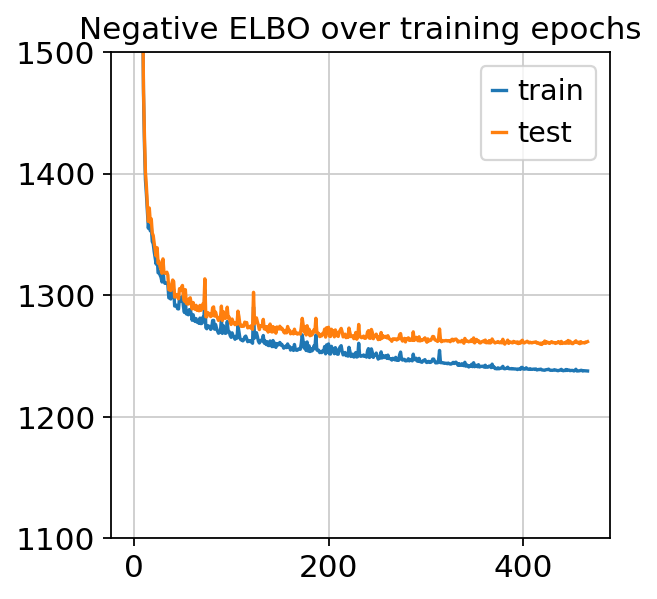

In [15]:
plt.plot(trainer.history["elbo_train_set"], label="train")
plt.plot(trainer.history["elbo_test_set"], label="test")
plt.title("Negative ELBO over training epochs")
plt.ylim(1100, 1500)
plt.legend()

## Analyze outputs

We use scanpy to do clustering, umap, visualization after running totalVI.

In [0]:
# create posterior on full data
full_posterior = trainer.create_posterior(type_class=TotalPosterior)
# update the batch size for GPU operations on Colab
full_posterior = full_posterior.update({"batch_size":32})

# extract latent space
latent_mean = full_posterior.get_latent()[0]

# Number of Monte Carlo samples to average over
n_samples = 25
# Probability of background for each (cell, protein)
py_mixing = full_posterior.sequential().get_sample_mixing(n_samples=n_samples, give_mean=True)
parsed_protein_names = [p.split("_")[0] for p in dataset.protein_names]
protein_foreground_prob = pd.DataFrame(
    data=(1 - py_mixing), columns=parsed_protein_names
)
# We condition here on batch 0, where all the proteins were observed
# The denoised expression accounts for measurement uncertainty and removes protein background
denoised_genes, denoised_proteins = full_posterior.sequential().get_normalized_denoised_expression(
    n_samples=n_samples, give_mean=True, transform_batch=0
)

# To compare to the held-out data we also include the background component of expression
# This would be the mean of the negative binomial mixture
protein_means = full_posterior.get_protein_mean(n_samples=n_samples, transform_batch=0)

<div class="alert alert-info">

Note

In most instances, we'd use the `denoised_proteins` for downstream analysis, but to compare to the observed data, we use the `protein_means`, which includes the foreground and background components.

</div>

In [0]:
post_adata = anndata.AnnData(X=dataset.X)
post_adata.obsm["X_totalVI"] = latent_mean
d_names = ["PBMC 10k", "PBMC 5k"]
post_adata.obs["batch"] = pd.Categorical(d_names[b] for b in dataset.batch_indices.ravel())
sc.pp.neighbors(post_adata, use_rep="X_totalVI", n_neighbors=25, metric="correlation")
sc.tl.umap(post_adata, min_dist=0.5)
sc.tl.leiden(post_adata, key_added="leiden_totalVI", resolution=0.8)

Trying to set attribute `.uns` of view, copying.


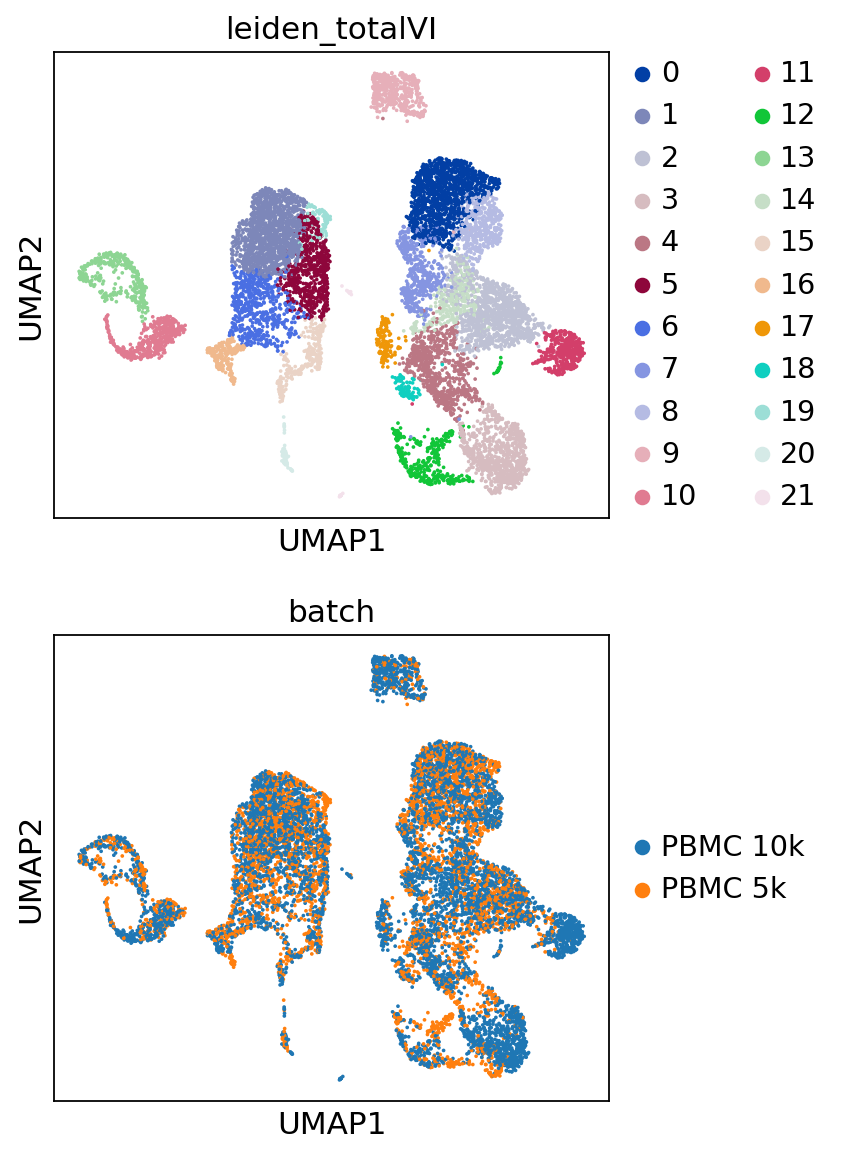

In [18]:
perm_inds = np.random.permutation(len(post_adata))
sc.pl.umap(
    post_adata[perm_inds], 
    color=["leiden_totalVI", "batch"],
    ncols=1
)

In [0]:
combined_protein = np.concatenate([dataset_10k.protein_expression, dataset_5k.protein_expression], axis=0)

for i, p in enumerate(parsed_protein_names):
    post_adata.obs["{}_fore_prob".format(p)] = protein_foreground_prob[p].values
    post_adata.obs["{} imputed".format(p)] = protein_means[:, i]
    post_adata.obs["{} observed".format(p)] = combined_protein[:, i]

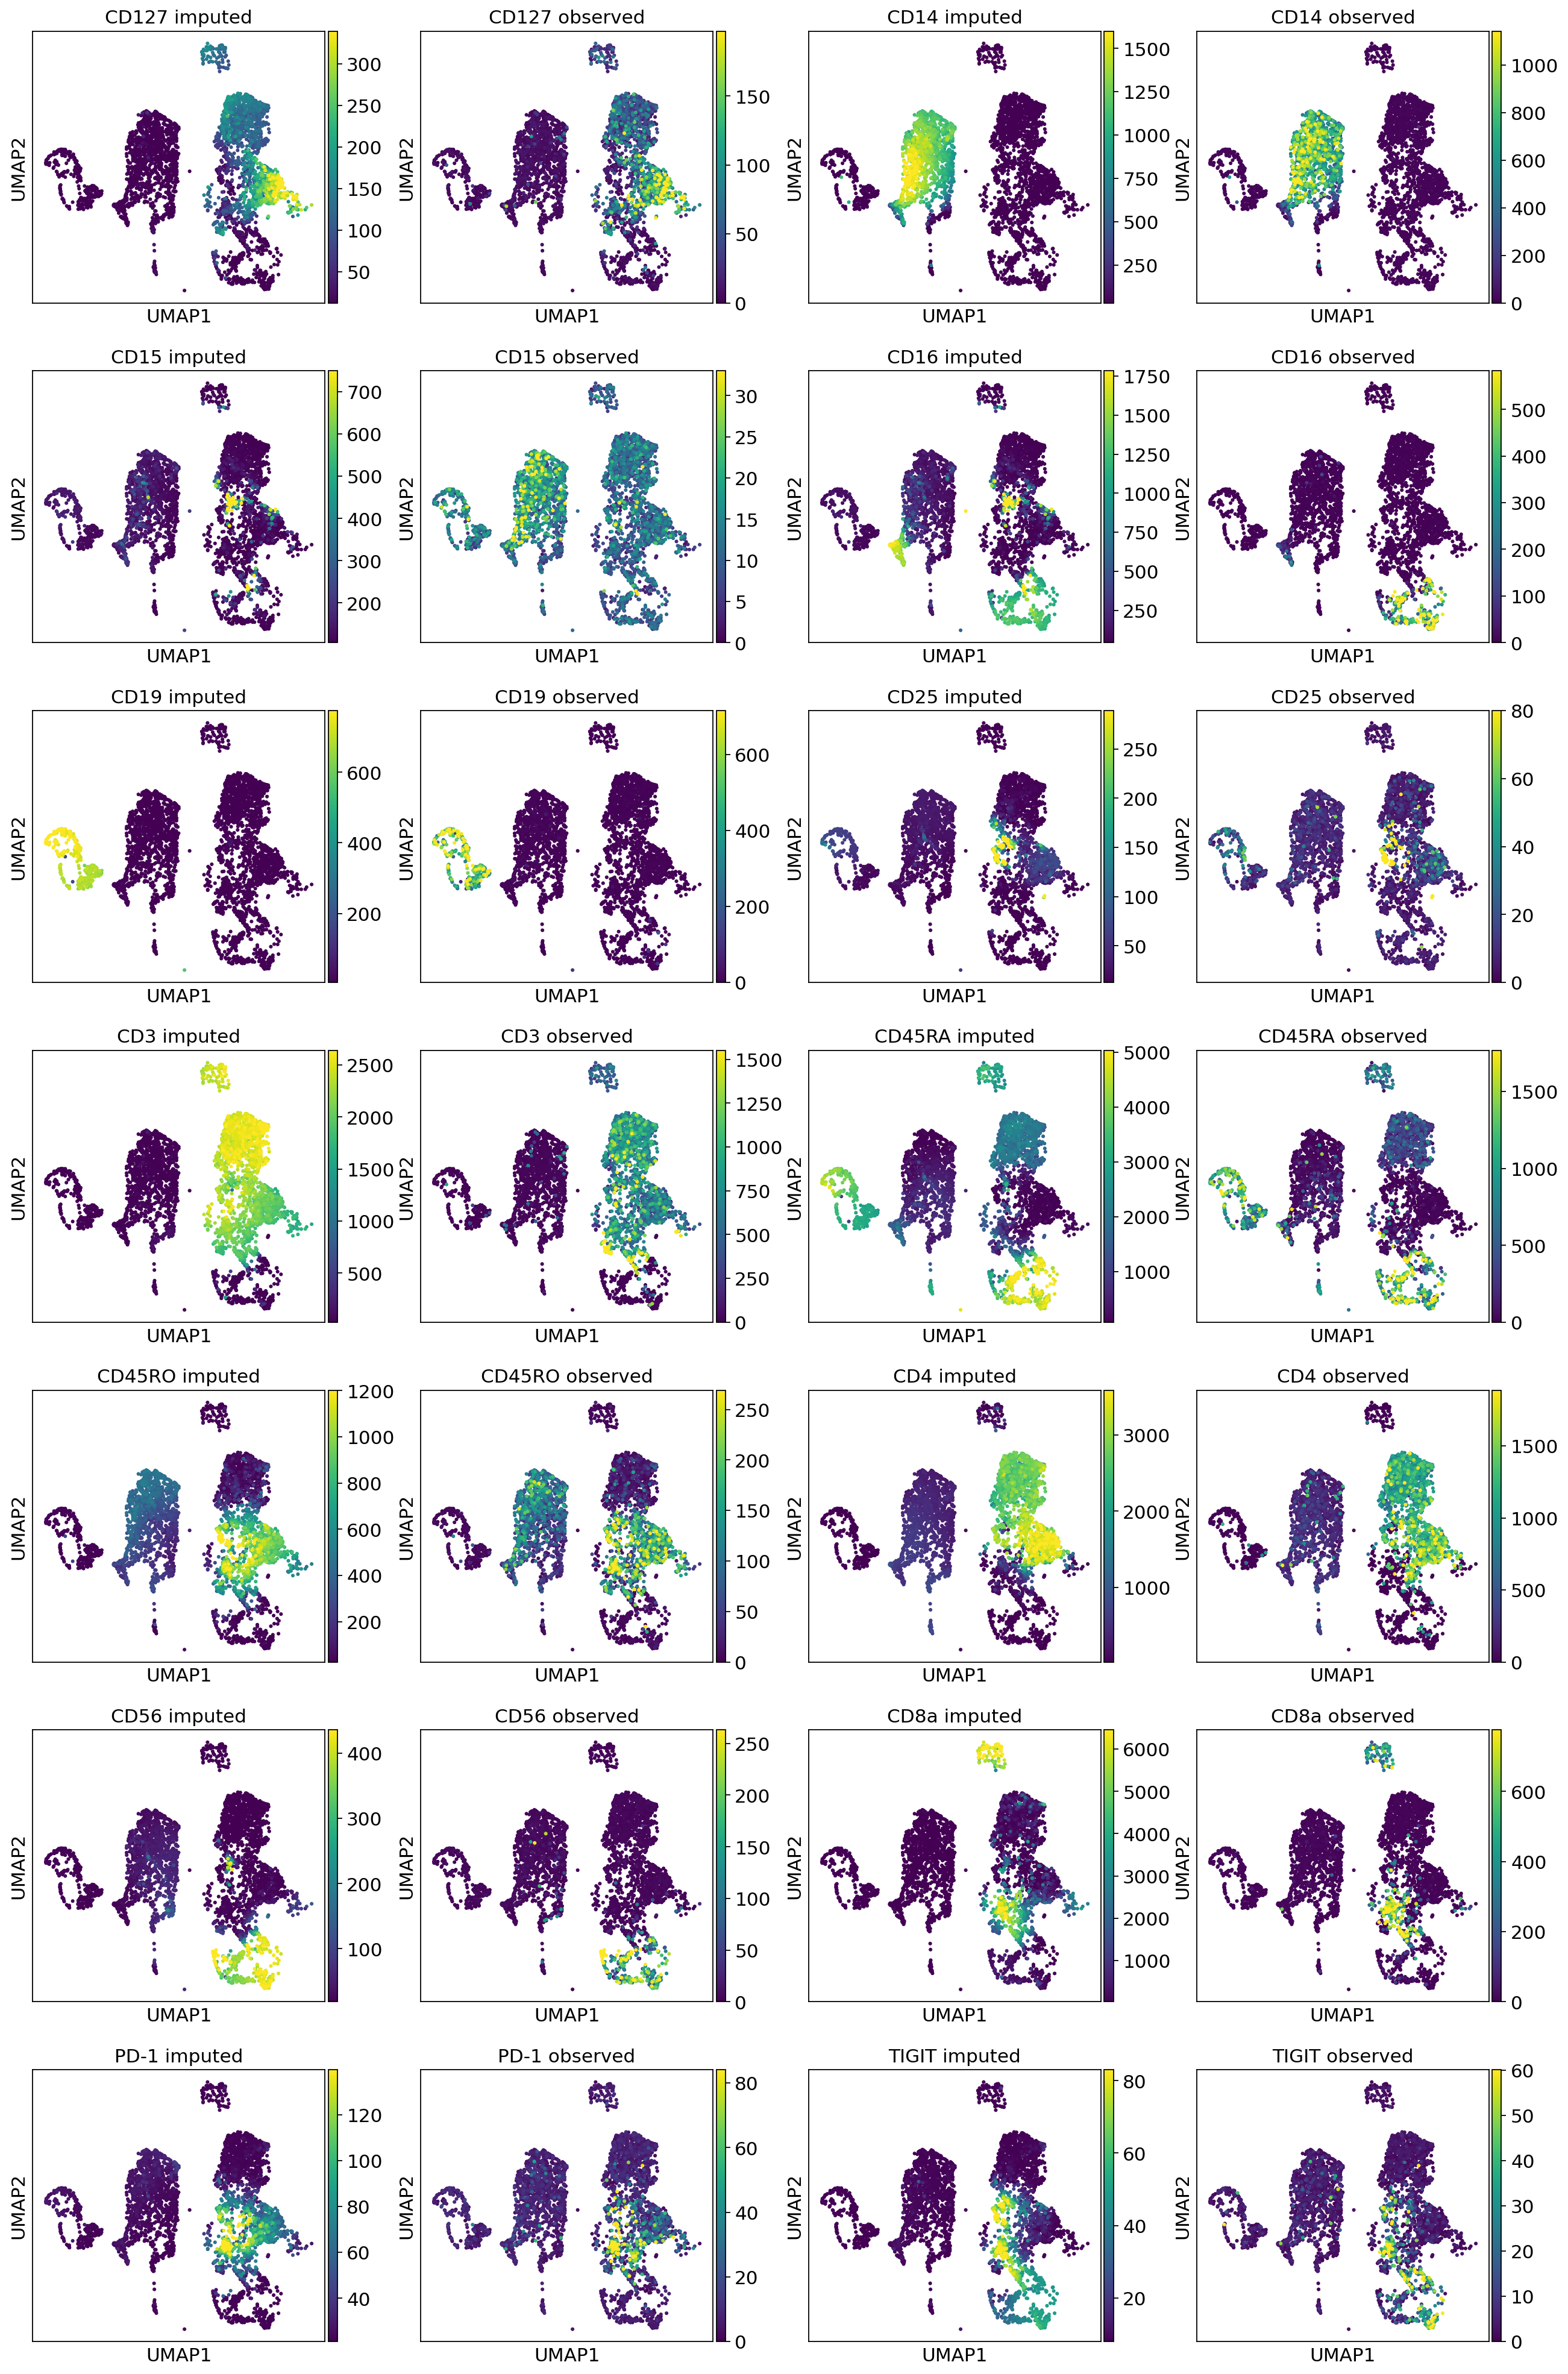

In [20]:
viz_keys = []
for p in parsed_protein_names:
    viz_keys.append(p + " imputed")
    viz_keys.append(p + " observed")

sc.pl.umap(
    post_adata[dataset.batch_indices.ravel() == 1],
    color=viz_keys,
    ncols=4,
    vmax="p99"
)

## Imputed vs denoised correlations

In [21]:
from scipy.stats import pearsonr
imputed_pros = protein_means[dataset.batch_indices.ravel() == 1]
held_vs_denoised = pd.DataFrame()
held_vs_denoised["Observed (log)"] = np.log1p(held_out_proteins.ravel())
held_vs_denoised["Imputed (log)"] = np.log1p(imputed_pros.ravel())
protein_names_corrs = []
for i, p in enumerate(parsed_protein_names):
    protein_names_corrs.append(parsed_protein_names[i] + ": Corr=" + str(np.round(pearsonr(held_out_proteins[:, i], imputed_pros[:, i])[0], 3)))
held_vs_denoised["Protein"] = protein_names_corrs * len(held_out_proteins)
held_vs_denoised.head()

Observed (log)  Imputed (log)            Protein
0        1.098612       2.640898  CD127: Corr=0.774
1        6.546785       7.182026   CD14: Corr=0.907
2        2.995732       4.752551   CD15: Corr=0.027
3        2.397895       4.476381   CD16: Corr=0.523
4        1.945910       1.911638   CD19: Corr=0.892

We notice that CD15 has a really low correlation in this data. Recall that imputation involves a counterfactual query -- "what would the protein expression have been for these cells if they came from the PBMC10k dataset?" Thus, any technical issues with proteins in CD15 in PBMC10k will be reflected in the imputed values. It's the case here that CD15 was not captured as well in the PBMC10k dataset compared to the PBMC5k dataset.

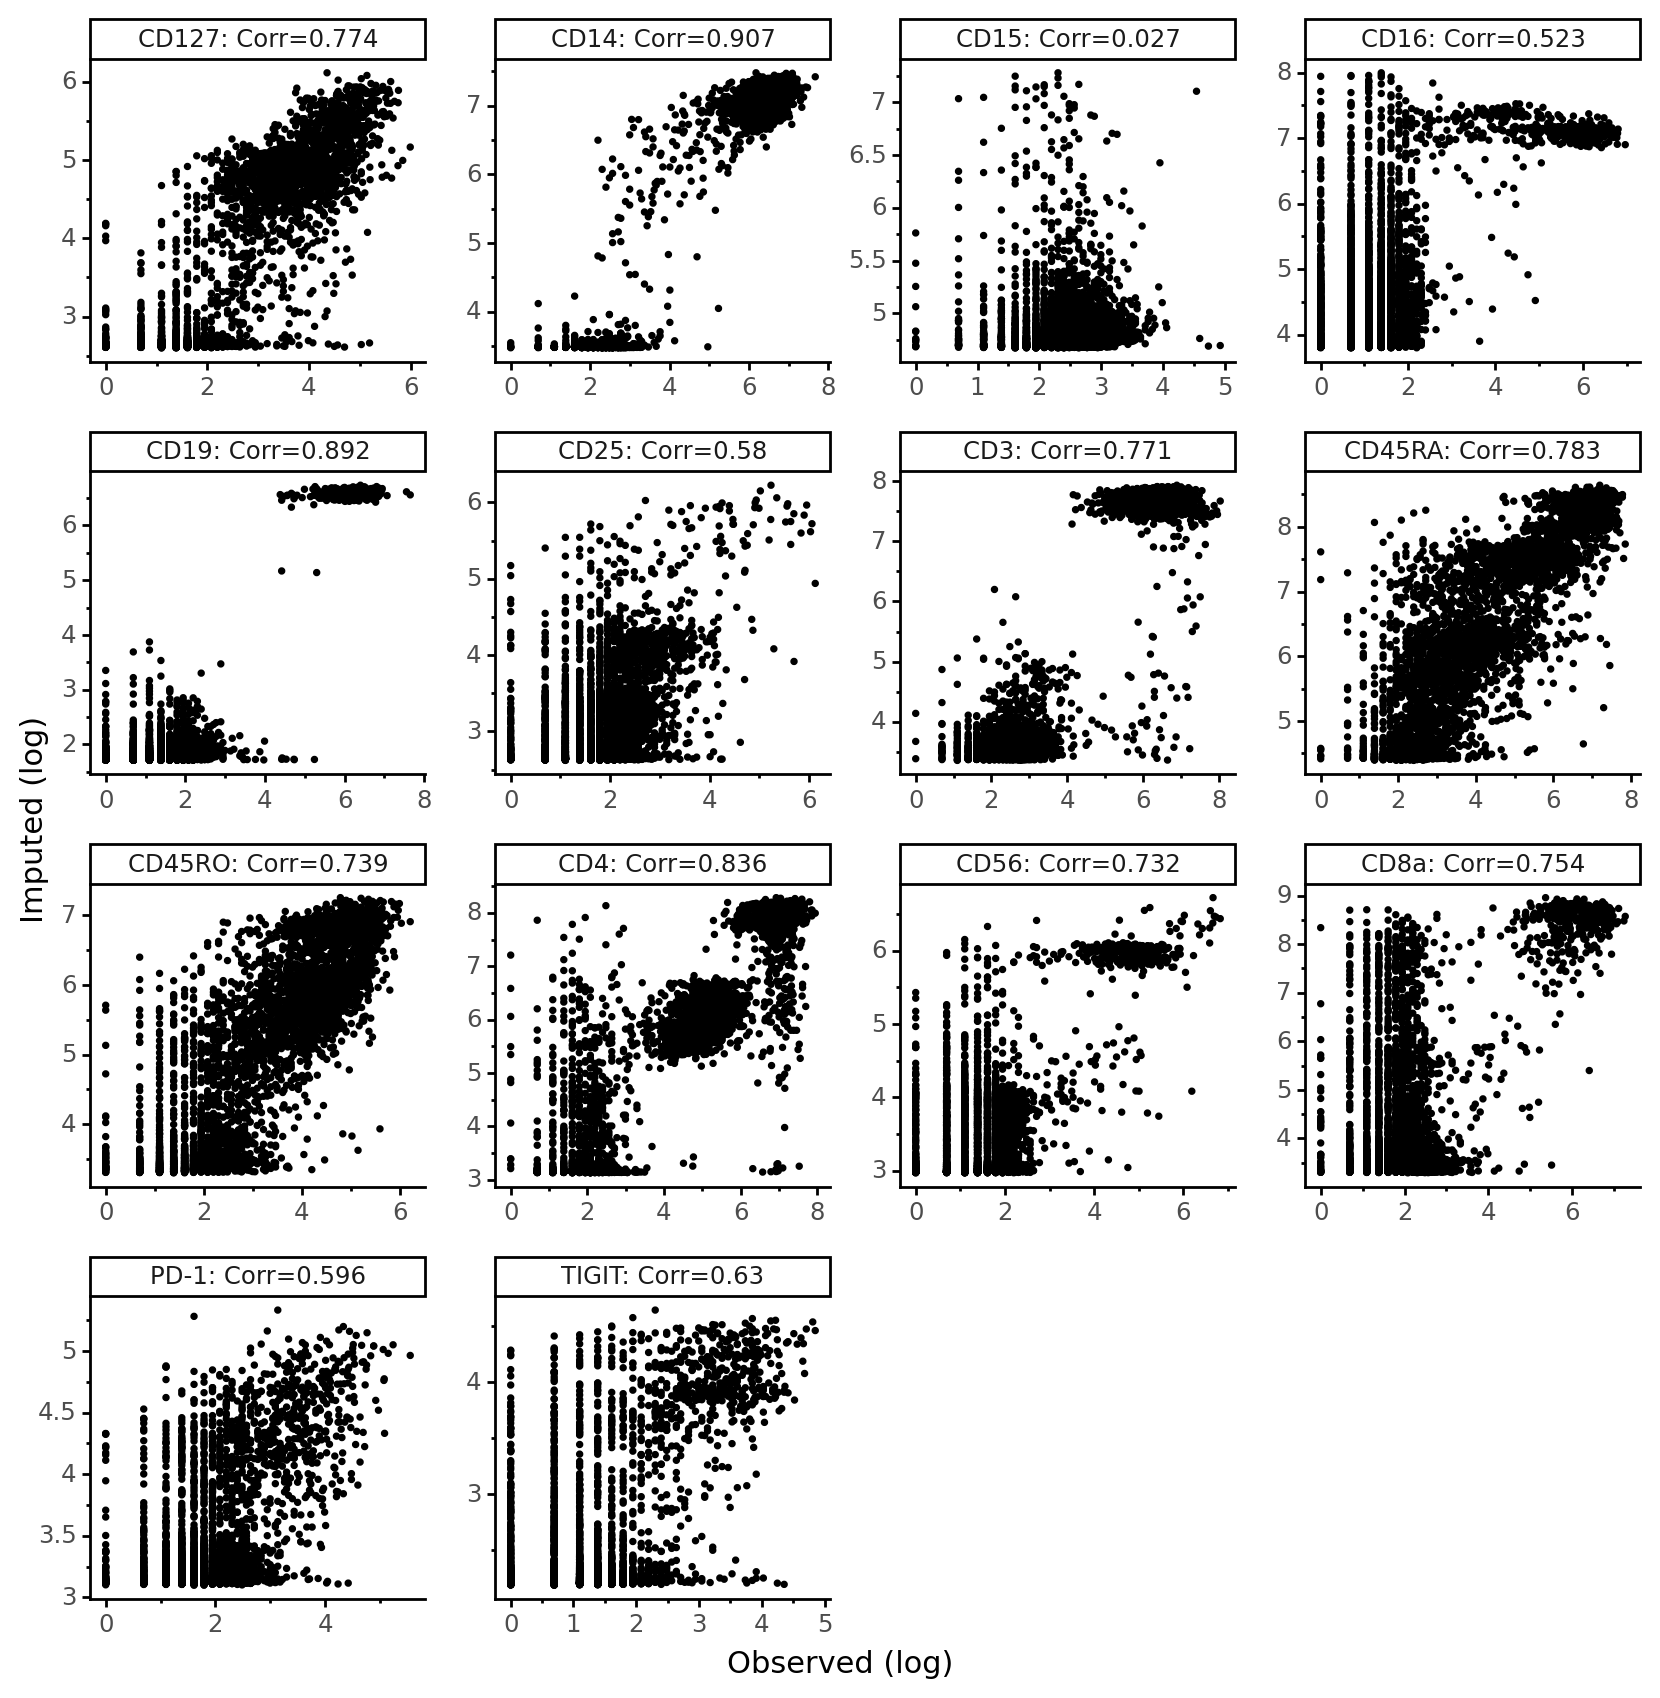

<ggplot: (-9223363283878535420)>

In [22]:
theme_set(theme_classic)
(ggplot(held_vs_denoised, aes("Observed (log)", "Imputed (log)"))
 + geom_point(size=0.5)
 + facet_wrap("~Protein", scales="free")
 + theme(figure_size=(10, 10), panel_spacing=.35,)
)
